# SEN163A - Fundamentals of Data Analytics
# Assignment 3 - Large-scale Internet Data Analysis
### Ir. Jacopo De Stefani - [J.deStefani@tudelft.nl](mailto:J.deStefani@tudelft.nl)
### Joao Pizani Flor, M.Sc. - [J.p.pizaniflor@tudelft.nl](mailto:J.p.pizaniflor@tudelft.nl)

### 01-04-2022
## Group 2
- Emmanuel M Boateng - '5617642'
- Joost Oortwijn - '4593472'
- Philip Busscher - ''4611993''
- Floris Kool - ''4975243''


# Introduction
The newspaper Tabularazor inc. has had an electrical malfunction causing a loss of data. Luckily they have a backup prepared. The backup from Tabularazor inc. not only contains articles, but also some metadata like author name and publishing date. In this assignment we will use this metadata to deduce some interesting facts about Tabularazors employees.

We will start of by describing the backup, how we worked and then describe how data is retrieved from the backup. After this we will load this data and transform it so we can use it for analysis. Lastly the data is analyzed and conclusions will be given after each finding.

# 1. Dataset description

The provided dataset contains an archief of a newpaper company with publications from to year 2012 till 2019. The only usable information in the datasets are the publication date, publication time and the responsible author. Based on these three attributes further analysis will be conducted.

The data can be found on a website. That means that the data is stored on a webserver and a specific approach is required to obtain the data in the form of aN HTML file. This process is called webscraping. To enable webscraping the python library Beautifulsoup is selected. This library contains the tools to work with HTML files like the provided data. Though, to obtain the data from the webserver, another library is necessary to generate HTTP requests. This library is called: requests

In [50]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import pandas as pd
import time
import pickle
import datetime
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt 

### Globally used variable names
Complete_df - Dataframe with the author name, date and time for every article

Employees_df - Dataframe with for each author and each day a field containing:
 - (0) Not_employed
 - (1) Working
 - (2) Offday
 - (3) Weekend_Working
 - (4) Weekend_Offday
 
Potential_Couples - List of all possible pairs of two authors

couples_df - Dataframe with the following information for each author:
 - Number of days at least one of the couple wasn't employed
 - Number of days both people were working
 - Number of days only one of the couple was working
 - Number of days neither people were working during a weekend
 - Number of days neither people were working on a workday
 - Ratio of days worked together over days that one person was working
 - Ratio of days they were off together over days that only one person was off
 


## 1.1 Webscraping

In [ ]:
#READING MAIN PAGE
#Get file
source_link = "https://jdestefani.github.io/SEN163A-TabularRazorArchives/"
response = requests.get(source_link)

#Read main file
main_page = BeautifulSoup(response.text)

for year_link in main_page.find_all('a', href=True):
    #READING YEAR PAGE & SAVING PKL FILE FOR EACH YEAR
    
    #Get file name of pkl file
    year_filename = year_link.get('href')
    year_filename = year_filename.removeprefix('./')
    year_filename = year_filename.removesuffix('.html')
    year_filename = "data/" + year_filename + ".pkl"
    
    #Clear lists of data for each year
    Data_Tuple = []
    
    #Get file  
    year_link = urljoin(source_link, year_link.get('href')) 
    response = requests.get(year_link)
    
    #Read year file
    year_page = BeautifulSoup(response.text)
     
    for month_link in year_page.find_all('a', href=True):
        #Get file
        month_link = urljoin(year_link, month_link.get('href'))
        response = requests.get(month_link)
        
        #Read month file
        month_page = BeautifulSoup(response.text)
        i = 0
        
        start  = time.time()
        
        for article_link in month_page.find_all('a', href=True):        
            #Get file
            article_link = urljoin(month_link, article_link.get('href')) 
            response = requests.get(article_link)
        
            #Read article file
            article_page = BeautifulSoup(response.text)
                       
            for div_element in article_page.find_all('div'):
                if div_element.get('class') == ['author']:
                    article_author = div_element.get_text()
                if div_element.get('class') == ['date']:
                    article_date = div_element.get_text()
                if div_element.get('class') == ['time']:
                    article_time = div_element.get_text()

            #Add data
            Data_Tuple.append((article_author, article_date, article_time))
            i += 1 
            #if i >= 10:
            #    break
        
        #Print after each month
        dur = round(time.time() - start,2)
        print('Read: ' + month_link)
        print('Added: ' + str(i) + ' articles')
        print('Duration: ' + str(dur) + ' seconds')
        
        #break

    #Save file after each year
    print()
    print("---")
    print("Saving: " + year_filename)
    df = pd.DataFrame(Data_Tuple)
    df.to_pickle(year_filename)
    print("Saved: " + str(len(df[0])) + " articles")
    print("---")
    print()
    
    #break
    

## 1.2 Opening the dataset

In [51]:
Complete_df = pickle.load(open("data/2012_2019.pkl", "rb"))
Complete_df = Complete_df.reset_index()
Complete_df = Complete_df.drop(['index'], axis=1) 
Complete_df.columns = ['Author','Date','Time']

Complete_df.head()

,Author,Date,Time
0,Jaye Shimek,2012-01-01,15:17:00
1,Leandro Marse,2012-01-01,10:52:00
2,Annie Lapham,2012-01-02,14:36:00
3,Annie Lapham,2012-01-02,15:38:00
4,Annie Lapham,2012-01-02,09:47:00


# 2 Analysis

The following analysis focuses on investigating how collegues at Tubularazor are related to eachother. Observing the author names, publication dates and time of the articles, certain patterns can be observed. These patterns are able to clearify what kind of relations the employees have with respect to eachother. We will look to find couples within Tebularazors authors, whether an author has had extended leave due to possible child birth and the average amount of holidays for employees of Tubularazor

## 2.1 Tranform data

We will start by transforming the raw data into a dataset useful for our analysis questions. For our analysis we only need for each author on what day they have posted an article. This way we can deduce on what days people were working, which will be used in the questions.

After doing this we can add some extra information. An author might not be employed throughout the entire period that we're analyzing. We're using the date they first and last posted to deduce when someone might have started or stopped working for Trebularazor. We also noticed that there are significantly less articles posted in the weekend. We also want to include this information. The result is a dataset with a field for each author on each day that can have the following value:
- Not employed
- Working
- Day off
- Working on weekend
- Weekend day off

In [52]:
# Create a dataframe with all the publication dates per author
merged_groupby = Complete_df.groupby(['Author'])['Date'].unique().apply(list).reset_index()
merged_groupby = merged_groupby.set_index('Author')

# Split the list with publication dates to a column
split_df = pd.DataFrame(merged_groupby['Date'].tolist())
split_df = split_df.set_index(merged_groupby.index)
split_df = split_df.astype(str)

# Create range of dates from the beginning of 2012 till the end of 20190
start = datetime.datetime.strptime("2012-1-1", "%Y-%m-%d")
end = datetime.datetime.strptime("2019-12-31", "%Y-%m-%d")
date_generated = pd.date_range(start, end)

# Create new dataframe with only zero's 
zero_df = pd.DataFrame(np.zeros((len(split_df), len(date_generated)), np.uint8))
zero_df = zero_df.set_index(merged_groupby.index)
zero_df.columns = date_generated
zero_df.columns = zero_df.columns.strftime("%Y-%m-%d")

In [53]:
# Fill the new dataframe (with zero's) with ones in case an author has published on a specific date
list_index = list(split_df.index.values)

for i in list_index:
    for j in range(split_df.shape[1]):
        date = split_df.loc[i,j]
        if np.isnat(np.datetime64(date))==True:
            break
        else:
            zero_df.loc[i,date]=1

Creating a dataframe with all employees and all days containing:
 - (0) Not_employed
 - (1) Working
 - (2) Offday
 - (3) Weekend_Working
 - (4) Weekend_Offday

In [14]:
#Create dataframe
#Fill with Not_employed until their first publication
#Fill with workdays and offdays based on publication
Employees_Data = []

for employee in zero_df.iterrows():
    days = []
    startedworking = False
    
    for day in employee[1]:
        if day == 1:
            startedworking = True
            days.append(1) #Working
        else:
            if startedworking:
                days.append(2) #Offday
            else:
                days.append(0) #Not_employed
    
    Employees_Data.append(days)
                
Employees_df = pd.DataFrame(Employees_Data, columns = date_generated.strftime("%Y-%m-%d"))
Employees_df.index = zero_df.index

#Employees_df

In [15]:
#Fill not employed based on last publication day
rowindex = 0

for employee in Employees_df.iterrows():    
    
    #Run through the days reversed to find last publication day
    columnindex = len(employee[1])
    
    for day in reversed(employee[1]): 
        columnindex -= 1

        if day == 1:
            break
        else:        
            Employees_df.iat[rowindex,columnindex] = 0 #Not_employed    
            
    rowindex += 1

In [16]:
# Change weekend days to right lables
from datetime import datetime
for i in list(Employees_df.index.values):
    for j in list(Employees_df.columns):
        year = int(j[:4])
        month = int(j[5:7])
        day = int(j[-2:])
        date = datetime(year,month,day)
        if date.weekday() > 4:
            if Employees_df.loc[i,j] == 1:
                Employees_df.loc[i,j] = 3
            elif Employees_df.loc[i,j] == 2:
                Employees_df.loc[i,j] = 4

In [17]:
# Final df with correct labels
Employees_df

,2012-01-01,2012-01-02,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-07,2012-01-08,2012-01-09,2012-01-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
Author,,,,,,,,,,,,,,,,,,,,,
Adriene Wilde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andreas Jost,0,1,1,1,1,1,4,4,1,1,...,4,1,1,1,1,1,4,4,1,1
Angela Compos,0,0,0,0,0,0,0,0,0,0,...,4,2,1,1,1,1,4,4,1,1
Anisha Mathes,0,1,2,2,2,1,3,4,2,1,...,4,1,1,1,1,1,4,4,1,1
Annie Lapham,0,1,1,1,2,1,4,4,1,1,...,4,1,1,1,2,1,4,4,1,1
Augusta Beltrami,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aurea Durrance,0,1,1,1,1,1,4,4,1,1,...,4,1,1,1,1,1,4,4,1,1
Bebe Riva,0,1,1,1,1,1,4,4,1,1,...,4,1,1,1,1,1,4,4,1,1
Bridgette Marko,0,1,1,1,1,1,4,4,1,1,...,4,1,1,1,1,1,4,4,1,1


## 2.2 Couple among employees (Question a)

The first test that will be conducted is whether there are couples among the authors and if they are still together.

In [19]:
#Create list of all potential couples
authors = set(merged['Author'])
potential_couples =  [couple for couple in combinations(authors,2)]  

potential_couples

[('Zofia Roll', 'Grover Gibbons'),
 ('Zofia Roll', 'Annie Lapham'),
 ('Zofia Roll', 'Hwa Defalco'),
 ('Zofia Roll', 'Vonk Billips'),
 ('Zofia Roll', 'Augusta Beltrami'),
 ('Zofia Roll', 'Remedios Fincham'),
 ('Zofia Roll', 'Donte Berkeley'),
 ('Zofia Roll', 'Byron Caroll'),
 ('Zofia Roll', 'Adriene Wilde'),
 ('Zofia Roll', 'Chung Zertuche'),
 ('Zofia Roll', 'Lester Preiss'),
 ('Zofia Roll', 'Lisette Tolleson'),
 ('Zofia Roll', 'Hettie Beller'),
 ('Zofia Roll', 'Corrine Gallop'),
 ('Zofia Roll', 'Tora Echevarria'),
 ('Zofia Roll', 'Johnetta Hatcher'),
 ('Zofia Roll', 'Jarvis Pratts'),
 ('Zofia Roll', 'Paulene Calcagni'),
 ('Zofia Roll', 'Mellisa Blanco'),
 ('Zofia Roll', 'Aurea Durrance'),
 ('Zofia Roll', 'Randall Feather'),
 ('Zofia Roll', 'Andreas Jost'),
 ('Zofia Roll', 'Velvet Matley'),
 ('Zofia Roll', 'Leandro Marse'),
 ('Zofia Roll', 'Jaye Shimek'),
 ('Zofia Roll', 'Marthe Hale'),
 ('Zofia Roll', 'Layne Woodside'),
 ('Zofia Roll', 'Lavonna Sim'),
 ('Zofia Roll', 'Hassan Toner'),
 

Creating a dataframe with all couple of employees containing:
 - Number of days at least one of the couple wasn't employed
 - Number of days both people were working
 - Number of days only one of the couple was working
 - Number of days neither people were working during a weekend
 - Number of days neither people were working on a workday

In [21]:
#LOADING WILL TAKE SOME TIME (2-3 minutes)

Not_Employed = []
Both_Working = []
One_Working = []
Weekend = []
Offdays = []
couples_data = []

start  = time.time()

#Check for all couples
for potential_couple in potential_couples:
    
    #Reset counters for each couple
    not_employed_count = 0
    both_working_count = 0
    one_working_count = 0
    weekend_count = 0
    offdays_count = 0
    templist = []
    
    #Select couple
    temp_df = Employees_df.loc[[potential_couple[0],potential_couple[1]]]
    
    for column in temp_df:
        
        #Checking both employees for:
        #0 - Not_employed
        #1 - Working
        #2 - Offday
        #3 - Weekend_Working
        #4 - Weekend_Offday
        
        #Add 1 to counter based on conditions mentioned in cell above
        if temp_df[column][0] == 0 or temp_df[column][1] == 0:
            not_employed_count += 1
        elif (temp_df[column][0] == 1 and temp_df[column][1] == 1) or (temp_df[column][0] == 3 and temp_df[column][1] == 3):
            both_working_count += 1
        elif (temp_df[column][0] == 1 or temp_df[column][1] == 1) or (temp_df[column][0] == 3 or temp_df[column][1] == 3):
            one_working_count += 1
        elif temp_df[column][0] == 4 and temp_df[column][1] == 4:
            weekend_count += 1
        else:
            offdays_count += 1
    
    #Add employee count data to tuple of lists
    templist.append(not_employed_count)
    templist.append(both_working_count)
    templist.append(one_working_count)
    templist.append(weekend_count)
    templist.append(offdays_count)           
    couples_data.append((templist))

#Create dataframe of all couples      
couples_df = pd.DataFrame(couples_data, columns = ['Not employed', 'Both working', 'One working', 'Weekend', 'Off days'])
couples_df.index = potential_couples[:len(couples_data)]

dur = round(time.time() - start,2)
print("Loading took: " + str(dur) + " seconds")

couples_df

Loading took: 150.93 seconds


,Not employed,Both working,One working,Weekend,Off days
"(Zofia Roll, Grover Gibbons)",1827,641,168,275,11
"(Zofia Roll, Annie Lapham)",1,1421,707,740,53
"(Zofia Roll, Hwa Defalco)",1,1767,411,728,15
"(Zofia Roll, Vonk Billips)",1,1767,395,733,26
"(Zofia Roll, Augusta Beltrami)",1827,639,178,267,11
...,...,...,...,...,...
"(Michale Tuch, Lorrine Paek)",2,1218,888,737,77
"(Michale Tuch, Bebe Riva)",1,1785,357,737,42
"(Vance Ates, Lorrine Paek)",1827,461,324,281,29
"(Vance Ates, Bebe Riva)",1827,668,136,277,14


To see if two people are a "couple" we assume they often work together and often take days off together. For all potential couples we will calculate two ratio's:
1. Days worked togeter over days that at least one person was working
2. Off days together over days that at least one person was not working

After some testing we noticed significant influences of days that people were unemployed and weekend days. If people were both not working for Trebulazor they had many "days off" together, by including the weekends we also had higher ratio's of people having many "days off" together. This is why we categorized these values in 2.1 and filtered for them in the cell below.

In [22]:
FreeTogether_Ratio = []
WorkTogether_Ratio = []

#Calculate ratio's for each couple by:
#Free days/ (Free days + One person working days)
#Both people working days/ (Both people working days + One person working days)

for potential_couple in couples_df.iterrows():
    
    #Added a divide by 0 check
    if potential_couple[1]['Off days'] + potential_couple[1]['One working'] != 0:
        FreeTogether_Ratio.append(potential_couple[1]['Off days']/(potential_couple[1]['Off days'] + potential_couple[1]['One working']))
    else:
        FreeTogether_Ratio.append(0)
    
    #Added a divide by 0 check
    if potential_couple[1]['Both working'] + potential_couple[1]['One working'] != 0:
        WorkTogether_Ratio.append(potential_couple[1]['Both working']/(potential_couple[1]['Both working'] + potential_couple[1]['One working']))
    else:
        WorkTogether_Ratio.append(0)

couples_df['Free_Ratio'] = FreeTogether_Ratio
couples_df['Work_Ratio'] = WorkTogether_Ratio

#couples_df


[Text(0.5, 0, 'Ratio'),
 Text(0, 0.5, '=Frequency'),
 Text(0.5, 1.0, 'Work days ratio')]

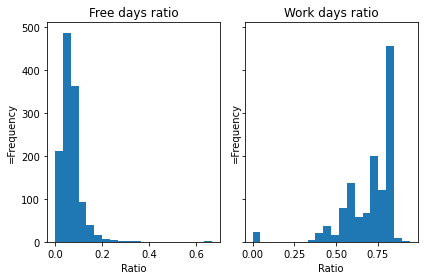

In [31]:
#Plot the distribution of ratio's to help find couples
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(couples_df['Free_Ratio'], bins=20)
axs[1].hist(couples_df['Work_Ratio'], bins=20)

axs[0].set(xlabel='Ratio', ylabel='=Frequency',
       title='Free days ratio')
axs[1].set(xlabel='Ratio', ylabel='=Frequency',
       title='Work days ratio')


In [32]:
Couples = []

#Cutoff values:
FREE_RATIO = 0.5
WORK_RATIO = 0.5

#Add couples with ratio's higher than the cutoff values
for potential_couple in couples_df.iterrows():
    if potential_couple[1]['Free_Ratio'] >= FREE_RATIO and potential_couple[1]['Work_Ratio'] >= WORK_RATIO:
        Couples.append(potential_couple[0])

print(len(Couples))

temp_df = couples_df.loc[Couples]

temp_df

1


,Not employed,Both working,One working,Weekend,Off days,Free_Ratio,Work_Ratio
"(Grover Gibbons, Augusta Beltrami)",1827,695,44,268,88,0.666667,0.94046


### Conclusion
To check which pair of authors might be a couple we use the ratio's described earlier. Using the cutoff values (in the cell above) we could set different thresholds for what a couple is and how often they would need to work together or take days off together. Before removing the weekend and not employed days we noticed many potential couples and changing the cutoff values changed the outcomes. 

After removing the weekend and not employed days however we only noticed one clear outlier: Grover Gibbons & Augusta Beltrami. Out of the 739 days they were working 695 days were worked together (94%) and out of 132 holidays 88 were at the same time (67%). 

## 2.3 Children (Question b)
Did any of the employees have a child? If so, who?

To deduce whether someone had a child we can use the number of days that people were not publishing for Tabularazor. Though we can only speculate why a person has a long period between publishing we will asume that if a person is away for longer than 80 days she is away for pregnancy leave.

In [45]:
#Use the complete dataset
Complete_df.head()

,Author,Date,Time
0,Jaye Shimek,2012-01-01,15:17:00
1,Leandro Marse,2012-01-01,10:52:00
2,Annie Lapham,2012-01-02,14:36:00
3,Annie Lapham,2012-01-02,15:38:00
4,Annie Lapham,2012-01-02,09:47:00


In [47]:
#find max time employees pauses for all employees

employees = Complete_df['Author'].unique().tolist()
d = []
for names in employees:
    df_f =  Complete_df.loc[Complete_df['Author']==names]
    diff = df_f['Date'].diff().max()
    #print(diff)
    d.append([names,diff])
    #print(names, df_f['Date'].diff().max())

#create a dataframe from the list
overview = pd.DataFrame(d,columns=['Author', 'Max_Absence'])
#convert to int
overview['Max_Absence'] = overview['Max_Absence'].dt.days
#sort the values
overview = overview.sort_values(by='Max_Absence', ascending=False)

#show the head.
overview.head()



,Author,Max_Absence
47,Corrine Gallop,136
20,Marthe Hale,128
17,Julieta Knapp,25
37,Augusta Beltrami,25
38,Grover Gibbons,25


### Conclusion
Looking at the time between publishing their are two clear outliers: Corrine Gallop and Marthe Hale. Both having around 130 days leave, with the 3rd highest time between posting being only 25 days. As mentioned earlier there could be many causes for this time between posting, but we will asume Corrine Gallop and Marthe Hale were on pregnancy leave.

## 2.4 Holidays (Question c)
If you would be looking to work for Tabularazor Inc., how many holidays can you expect to get per
year?

To answer how many holidays a person can expect when working at Tabularazor we will look at the amount of days an author was not publishing, ignoring the weekend days and days not employed. To do this we checked for each employee the ratio of days off over the days the employee is "supposed" to work. For each extra day worked in the weekend we substracted a holiday as the employee then worked more than the standard work days.

After calculating the ratio's we multiply this by the standard number of yearly working days to find the average amount of yearly holidays for each employee. To calculate the total average yearly holidays we calculated the average of all the employees average yearly holidays.

This method was useful for finding the average yearly holidays per employee. However to calculate the average of all employees it's more accurate to look at the total working days of all employees and days off of all employees. This way employees that worked at Tabularazor longer have more influence over the average than a person only working there temporary.

In [43]:

Off_Days = []
Work_Days = []
Ratios = []
Yearly_Holidays = []

#Amount of non weekend days per year
Yearly_Work_Days = (5 *365/7)


for employee in Employees_df.iterrows():    
    
    off_days = 0
    work_days = 0
    
    for day in employee[1]: 
        
        #Checking employee days for:
        #0 - Not_employed
        #1 - Working
        #2 - Offday
        #3 - Weekend_Working
        #4 - Weekend_Offday
        
        #Count the working days when this employee was employed
        if day != 0 and day != 4:
            work_days += 1
        #Count days off
        if day == 2:
            off_days += 1
        #Remove extra days worked from off days
        elif day == 3:
            off_days-= 1
    
    Off_Days.append(off_days)
    Work_Days.append(work_days)
    
    ratio = off_days/work_days
    Ratios.append(ratio)
    
    Yearly_Holidays.append(round(ratio * Yearly_Work_Days))
 
Employees_df["Off days"] = Off_Days
Employees_df["Work days"] = Work_Days
Employees_df["Off day ratio"] = Ratios
Employees_df["Yearly holidays"] = Yearly_Holidays

Average_Holidays = round(Employees_df["Yearly holidays"].mean())

print("Average yearly holidays: " + str(Average_Holidays))

Employees_df


Average yearly holidays: 31


,2012-01-01,2012-01-02,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-07,2012-01-08,2012-01-09,2012-01-10,...,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,Off days,Work days,Off day ratio,Yearly holidays
Author,,,,,,,,,,,,,,,,,,,,,
Adriene Wilde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,255,816,0.312500,81
Andreas Jost,0,1,1,1,1,1,4,4,1,1,...,1,1,4,4,1,1,110,2144,0.051306,13
Angela Compos,0,0,0,0,0,0,0,0,0,0,...,1,1,4,4,1,1,152,1005,0.151244,39
Anisha Mathes,0,1,2,2,2,1,3,4,2,1,...,1,1,4,4,1,1,332,2139,0.155213,40
Annie Lapham,0,1,1,1,2,1,4,4,1,1,...,2,1,4,4,1,1,506,2136,0.236891,62
Augusta Beltrami,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,63,812,0.077586,20
Aurea Durrance,0,1,1,1,1,1,4,4,1,1,...,1,1,4,4,1,1,336,2142,0.156863,41
Bebe Riva,0,1,1,1,1,1,4,4,1,1,...,1,1,4,4,1,1,114,2149,0.053048,14
Bridgette Marko,0,1,1,1,1,1,4,4,1,1,...,1,1,4,4,1,1,117,2143,0.054596,14


The average number of yearly holidays per employee is 31. However we can notice from the table that some employees get much more days off. Roughly speaking people that worked there less (likely temporary writers) get more days off. Though there are also other factors influencing this like extra leave for for example pregnancy.

In [49]:
Off_Days = 0
Work_Days = 0

for employee in Employees_df.iterrows():    
        
    for day in employee[1]: 
        
        #Checking employee days for:
        #0 - Not_employed
        #1 - Working
        #2 - Offday
        #3 - Weekend_Working
        #4 - Weekend_Offday
        
        #Count the working days when this employee was employed
        if day != 0 and day != 4:
            Work_Days += 1
        #Count days off
        if day == 2:
            Off_Days += 1
        #Remove extra days worked from off days
        elif day == 3:
            Off_Days -= 1
            
Ratio = Off_Days/Work_Days

#print(Off_Days)
#print(Work_Days)
#print(Ratio)

Yearly_Work_Days = (5 *365/7)

Average_Holidays = round(Yearly_Work_Days * Ratio)

print("Average yearly holidays: " + str(Average_Holidays))

Average yearly holidays: 29


### Conclusion
When taking into account how long each author worked at the company we get a slightly lower average yearly holidays: 29 days
